In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


In [2]:
import argparse
import collections
import numpy as np
import pyro
import torch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
import trainer.trainer as module_trainer

In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [5]:
from utils import read_json

config = read_json("experiments/ppc_celeba_config.json")
config = ConfigParser(config)

In [6]:
logger = config.get_logger('train')

# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
logger.info(model)

# get function handles of metrics
metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer.
if "lr_scheduler" in config:
    lr_scheduler = getattr(pyro.optim, config["lr_scheduler"]["type"])
    lr_scheduler = optimizer = lr_scheduler({
        "optimizer": getattr(torch.optim, config["optimizer"]["type"]),
        "optim_args": config["optimizer"]["args"]["optim_args"],
        **config["lr_scheduler"]["args"]
    })
else:
    optimizer = config.init_obj('optimizer', pyro.optim)
    lr_scheduler = None

# build trainer
# kwargs = config['trainer'].pop('args')
trainer = config.init_obj('trainer', module_trainer, model, metrics, optimizer,
                          config=config, data_loader=data_loader,
                          valid_data_loader=valid_data_loader,
                          lr_scheduler=lr_scheduler)

Files already downloaded and verified
CelebAPpc(
  (prior): GaussianPrior()
  (likelihood): ConvolutionalDecoder(
    (linear): Sequential(
      (0): Linear(in_features=40, out_features=256, bias=True)
      (1): SiLU()
    )
    (convs): Sequential(
      (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
      (1): SiLU()
      (2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): SiLU()
      (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): SiLU()
      (6): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): SiLU()
      (8): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): SiLU()
      (10): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
  )
  (graph): PpcGraphicalModel()
)
Trainable parameters: 454627
Initialize particles: train batch 0
Initialize particles: train batch 1
Initialize pa

In [7]:
logger.info(trainer.config.log_dir)

saved/log/CelebA_Ppc/0504_234243


In [8]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Epoch: 1 [0/146493 (0%)] Loss: 47484.246094
Train Epoch: 1 [92160/146493 (63%)] Loss: 45170.347656
    epoch          : 1
    loss           : 45730.767415364586
    ess            : 1.9887373447418213
    log_marginal   : -45730.76752387153
    val_loss       : 43965.54296875
    val_ess        : 1.98873732984066
    val_log_marginal: -43965.54345703125
Train Epoch: 2 [0/146493 (0%)] Loss: 44016.285156
Train Epoch: 2 [92160/146493 (63%)] Loss: 42176.007812
    epoch          : 2
    loss           : 42588.71120876736
    ess            : 1.9887373447418213
    log_marginal   : -42588.710828993055
    val_loss       : 41138.72509765625
    val_ess        : 1.98873732984066
    val_log_marginal: -41138.7255859375
Train Epoch: 3 [0/146493 (0%)] Loss: 41135.039062
Train Epoch: 3 [92160/146493 (63%)] Loss: 39443.617188
    epoch          : 3
    loss           : 39796.06228298611
    ess            : 1.9887373447418213
    log_marginal   : -39796.062174479164
    val_loss       : 383

In [9]:
trainer.model.eval()
trainer.model.cpu()
trainer.cpu()
trainer.train_particles.cpu()
trainer.valid_particles.cpu()

ParticleDict(  (z): Parameter containing: [torch.FloatTensor of size 2x16277x40])

In [10]:
trainer.model.graph.clear()
trainer._load_particles(range(trainer.data_loader.batch_size), False)

In [11]:
for site in trainer.model.graph.nodes:
    trainer.model.graph.nodes[site]['is_observed'] = trainer.model.graph.nodes[site]['value'] is not None

In [12]:
import utils

In [13]:
with pyro.plate_stack("forward", (trainer.num_particles, trainer.data_loader.batch_size)):
    model = pyro.condition(trainer.model, data={k: v['value'] for k, v in trainer.model.graph.nodes.items()})
    xs = model()

In [14]:
import matplotlib.pyplot as plt

generated new fontManager


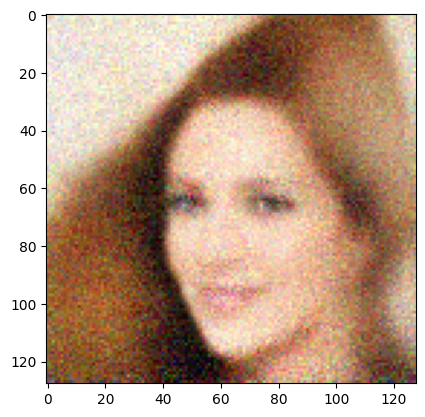

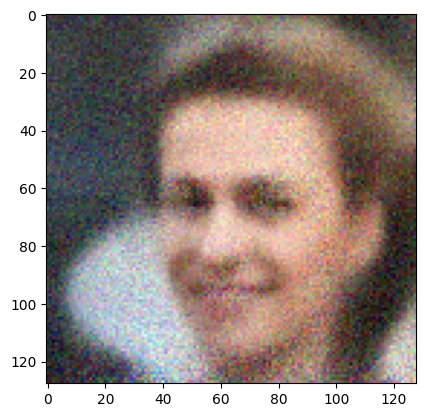

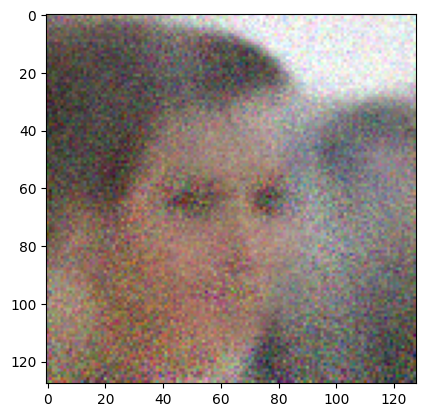

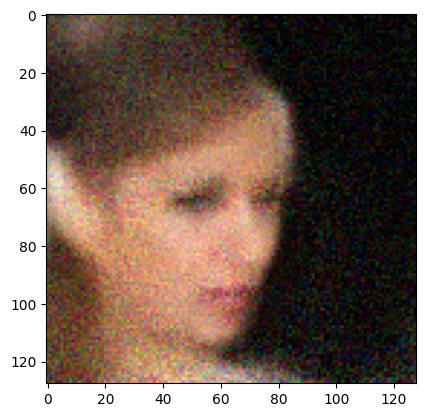

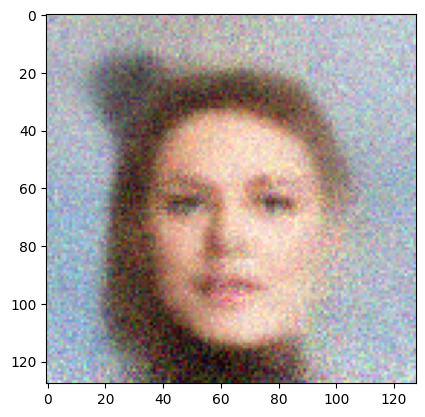

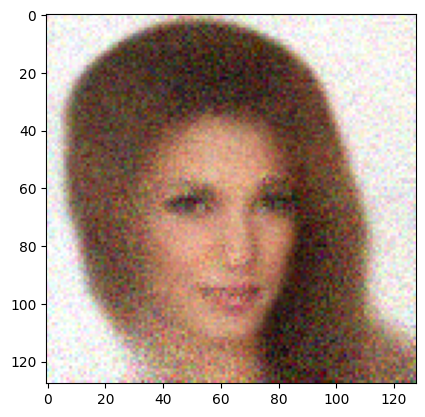

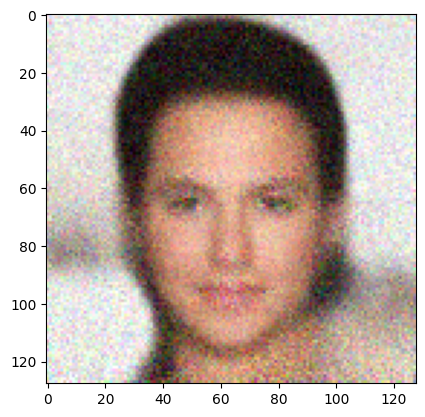

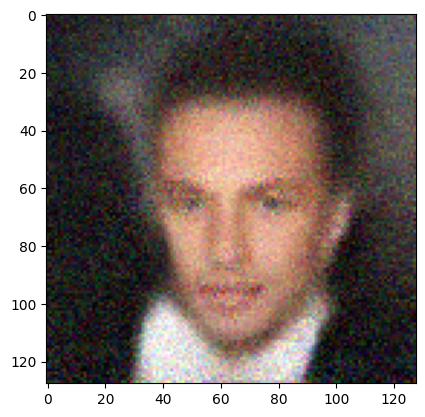

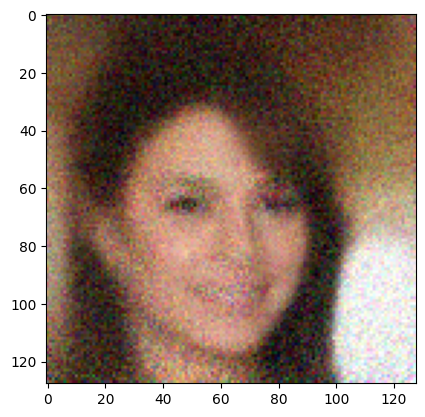

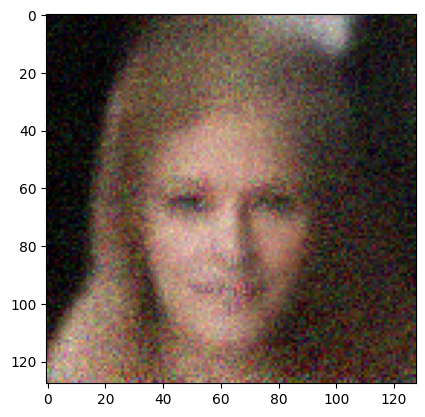

In [15]:
for i in range(10):
    plt.imshow(torch.clamp(xs.mean(dim=0)[i].squeeze(), 0, 1).detach().cpu().transpose(0, -1).numpy())
    plt.show()